In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Grid Generation Tutorial

> A basic introduction to Geospatial Grids

## Basic Usage
Creating a grid from a geojson file

In [5]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [6]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [7]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [8]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [9]:
# hide_input
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [10]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

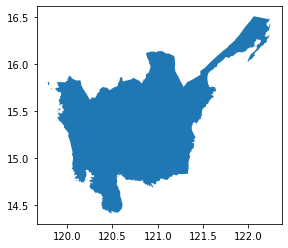

In [11]:
import matplotlib.pyplot as plt

ax = region3_gdf.plot(ax=plt.axes())

In [12]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
aoi_total_bounds = region3_gdf.total_bounds
aoi_total_bounds

array([119.7858332,  14.4075257, 122.2429921,  16.5092548])

## Square Grid Generator
### Creating Grids

Create a grid generator with a size of `5,000` m. 
The units of the grid size are dependent on the projection parameter  
of the grid generator. In this case, the [default is  `EPSG:3857`](https://epsg.io/3857).

In [14]:
grids.SquareGridGenerator?

Init signature:
grids.SquareGridGenerator(
    cell_size: float,
    grid_projection: str = 'EPSG:3857',
    boundary: Union[geowrangler.grids.SquareGridBoundary, List[float]] = None,
)
Docstring:      <no docstring>
File:           ~/repos/geowrangler/geowrangler/grids.py
Type:           type
Subclasses:     


In [15]:
grid_generator5k = grids.SquareGridGenerator(5_000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [16]:
%%time
# slow
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 733 ms, sys: 8.07 ms, total: 741 ms
Wall time: 741 ms


<AxesSubplot:>

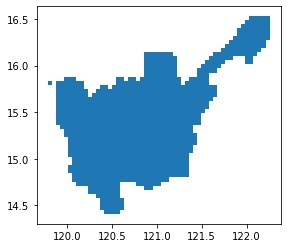

In [17]:
grid_gdf5k.plot()

Show gridded version of sample geojson file at 5K resolution 

In [18]:
# hide_input
# no_test
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1070 row(s)


In [19]:
# hide
# slow
# assert len(grid_gdf5k) == 1074

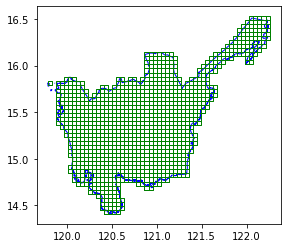

In [20]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [21]:
# slow
grid_gdf5k.head()

,x,y,geometry
0,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795..."
1,2,22,"POLYGON ((119.87566 15.36250, 119.92058 15.362..."
2,2,23,"POLYGON ((119.87566 15.40581, 119.92058 15.405..."
3,2,24,"POLYGON ((119.87566 15.44910, 119.92058 15.449..."
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492..."


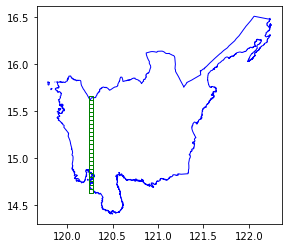

In [22]:
# slow
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [23]:
grid_generator15k = grids.SquareGridGenerator(15_000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [24]:
%%time
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 627 ms, sys: 11.5 ms, total: 639 ms
Wall time: 638 ms


Show gridded version of sample geojson file at 15K resolution 

In [25]:
# hide_input
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 150 row(s)


In [26]:
# hide
# assert len(grid_gdf15k) == 154

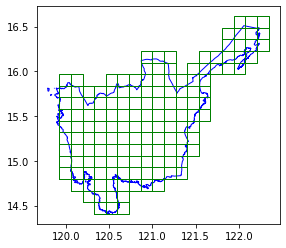

In [27]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [28]:
cell1 = grid_gdf15k.head(1)
cell2 = grid_gdf15k.tail(1)

In [29]:
pd.concat([cell1, cell2])

,x,y,geometry
0,1,3,"POLYGON ((119.92058 14.79871, 120.05533 14.798..."
149,18,16,"POLYGON ((122.21128 16.48548, 122.34603 16.485..."


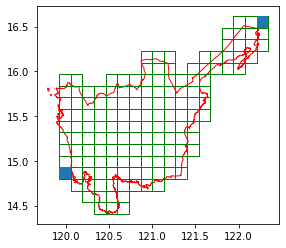

In [30]:
ax = region3_gdf.plot(facecolor="none", edgecolor="red")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")
ax = pd.concat([cell1, cell2]).plot(ax=ax)

In [31]:
grid_generator1k = grids.SquareGridGenerator(1_000, boundary=aoi_total_bounds)

In [32]:
%%time
gridcell1 = grid_generator1k.generate_grid(cell1)

CPU times: user 41.8 ms, sys: 0 ns, total: 41.8 ms
Wall time: 38.4 ms


In [33]:
len(gridcell1)

225

In [34]:
gridcell1.head()

,x,y,geometry
0,15,45,"POLYGON ((119.92058 14.79871, 119.92956 14.798..."
1,15,46,"POLYGON ((119.92058 14.80739, 119.92956 14.807..."
2,15,47,"POLYGON ((119.92058 14.81608, 119.92956 14.816..."
3,15,48,"POLYGON ((119.92058 14.82476, 119.92956 14.824..."
4,15,49,"POLYGON ((119.92058 14.83345, 119.92956 14.833..."


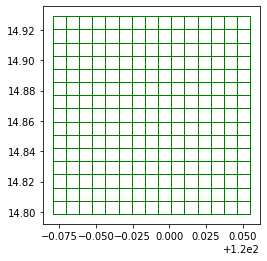

In [35]:
ax = gridcell1.plot(facecolor="none", edgecolor="green")

In [36]:
%%time
gridcell2 = grid_generator1k.generate_grid(cell2)

CPU times: user 23.9 ms, sys: 0 ns, total: 23.9 ms
Wall time: 23.1 ms


In [37]:
len(gridcell2)

12

In [38]:
gridcell2.head()

,x,y,geometry
0,270,240,"POLYGON ((122.21128 16.48548, 122.22027 16.485..."
1,270,241,"POLYGON ((122.21128 16.49409, 122.22027 16.494..."
2,270,242,"POLYGON ((122.21128 16.50270, 122.22027 16.502..."
3,271,240,"POLYGON ((122.22027 16.48548, 122.22925 16.485..."
4,271,241,"POLYGON ((122.22027 16.49409, 122.22925 16.494..."


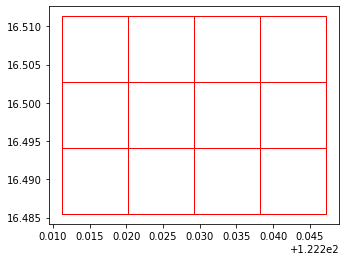

In [39]:
ax = gridcell2.plot(facecolor="none", edgecolor="red")

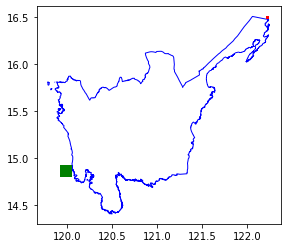

In [40]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = gridcell1.plot(ax=ax, color="green")
ax = gridcell2.plot(ax=ax, color="red")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, Grid Generator already optmizes the implementation for you


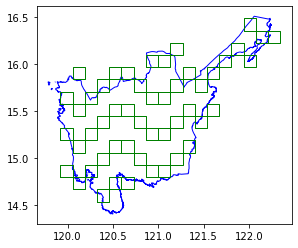

In [41]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [42]:
sparse_grid = grid_generator1k.generate_grid(sparse_aois)

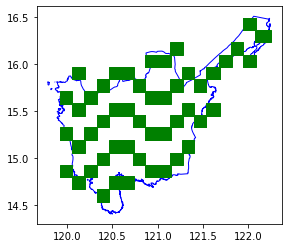

In [43]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

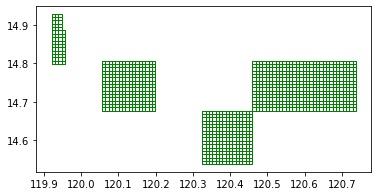

In [44]:
ax = sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

## H3 Grid Generator
### Generating grids
Let us generate grids of resolution 5. To learn more about the different resolution, visit: https://h3geo.org/docs/core-library/restable/

In [45]:
h3_generator = grids.H3GridGenerator(resolution=5)

In [46]:
%%time
h3_5_gdf = h3_generator.generate_grid(region3_gdf)

CPU times: user 3.41 s, sys: 27.4 ms, total: 3.44 s
Wall time: 3.43 s


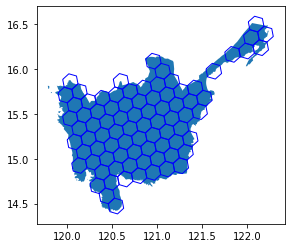

In [47]:
ax = region3_gdf.plot(aspect="equal")
ax = h3_5_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", aspect="equal")

### Not exporting geometry
If you do not plan to use use geometry, you can pass `return_geometry=False` to just get a normal pandas DataFrame with the ids.

In [48]:
h3_generator_no_geom = grids.H3GridGenerator(resolution=5, return_geometry=False)

In [49]:
%%time
h3_region3_no_geom = h3_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 3.48 s, sys: 52.2 ms, total: 3.53 s
Wall time: 3.53 s


In [50]:
len(h3_region3_no_geom)

84

In [51]:
h3_region3_no_geom.head()

,hex_id
0,856941a3fffffff
1,85696a7bfffffff
2,85694147fffffff
3,856943bbfffffff
4,85694e97fffffff


## Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12. To learn more about the different resolution, visit: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [52]:
bing_tile_grid_generator = grids.BingTileGridGenerator(12)

In [53]:
%%time
# slow
bing_tile_gdf = bing_tile_grid_generator.generate_grid(region3_gdf)

CPU times: user 7.65 s, sys: 19.3 ms, total: 7.67 s
Wall time: 7.67 s


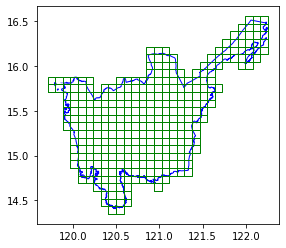

In [54]:
# no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

### Not exporting geometry

If you do not plan to use use geometry, you can pass return_geometry=False to just get a normal pandas DataFrame with the ids.


In [55]:
bing_tile_grid_generator_no_geom = grids.BingTileGridGenerator(
    12, return_geometry=False
)

In [56]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 7.63 s, sys: 27.1 ms, total: 7.65 s
Wall time: 7.66 s


In [57]:
# no_test
bing_region3_keys.head()

,quadkey
0,132303030330
1,132303030331
2,132303030313
3,132303012302
4,132303012031
